In [2]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
I = np.array([[1 , 0] , [0 , 1]])
from pfapack import pfaffian as pf

%matplotlib widget

### In this notebook:
- Reproducting specific band structures from the Pientka paper as a quick sanity check.
- Specifically Fig 7 in https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.021032

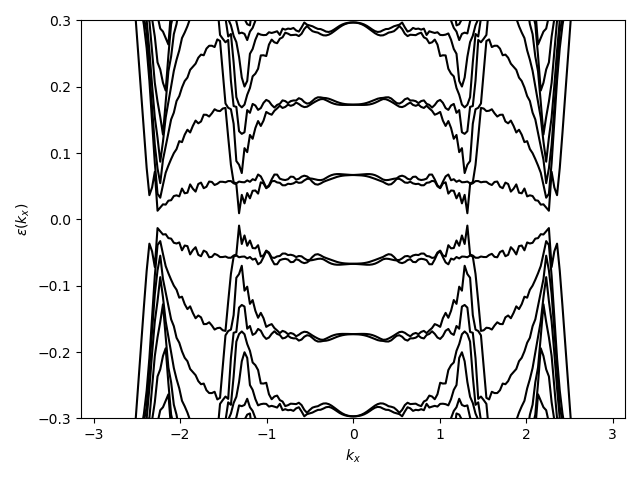

In [7]:
from scipy import constants
from sympy import exp
from josephson_current_tools import constants
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    t : float
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Delta : float # Superconducting gap
    phase : float # Phase bias of Josephson junction

def make_lead(params):

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    lat = kwant.lattice.square(a = params.a , norbs = 4)

    half_w = params.W // 2
    half_L_y = params.L_y // 2

    for j in range(params.L_y):

        # Bottom superconducting lead:
        if j < (half_L_y - half_w):
            lead[lat(0 , j)] = 4*params.t*np.kron(sz , I) - params.mu*np.kron(sz , I) + params.Delta*np.kron(sz , I)
        
        # Normal region with Zeeman coupling:
        if j >= (half_L_y - half_w) and j <= (half_L_y + half_w):
            lead[lat(0 , j)] = 4*params.t*np.kron(sz , I) - params.mu*np.kron(sz , I) + params.E_z*np.kron(I , sx)
        
        # Top superconducting lead:
        if j >= (half_L_y + half_w):
            lead[lat(0 , j)] = (4*params.t*np.kron(sz , I) - params.mu*np.kron(sz , I) + params.E_z*np.kron(I , sx) + params.Delta*np.exp(1j*params.phase)*np.kron(0.5*(sx + 1j*sy) , I) 
                                + params.Delta*np.exp(-1j*params.phase)*np.kron(0.5*(sx - 1j*sy) , I))
        
        # Hoppings in the x-direction:
        lead[lat(1 , j) , lat(0 , j)] = -params.t*np.kron(sz , I) + 1j*params.alpha*np.kron(sz , sy)

    # Hoppings in the y-direction:
    lead[kwant.builder.HoppingKind((0 , 1) , lat)] = -params.t*np.kron(sz , I) - 1j*params.alpha*np.kron(sz , sx)

    return lead.finalized()

params = parameters(a = 1 , L_x = 0, L_y = 45 , W  = 5 , t = 1, mu = 2.8 , alpha = 0.5 , E_z= 0.0 , Delta = 0.3 , phase = 0.0*np.pi)
syst = make_lead(params)
bands = kwant.physics.Bands(syst , params = asdict(params))
momenta = np.linspace(-np.pi , np.pi , 201)
energies = [bands(k) for k in momenta]
fig , ax = plt.subplots()
ax.plot(momenta , energies , color = 'k');
ax.set_xlim(left = -np.pi , right = np.pi)
ax.set_ylim(bottom = -params.Delta , top = params.Delta)
ax.set_xlabel(r'$k_{x}$')
ax.set_ylabel(r'$\epsilon(k_{x})$')
plt.tight_layout()





In [3]:
np.kron(sz , I)

array([[ 1,  0,  0,  0],
       [ 0,  1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0, -1]])